In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import edward.models as edm
from edward.models import Normal

plt.style.use('ggplot')

In [2]:
def build_toy_dataset(N=50, noise_std=0.1):
    x = np.linspace(-3, 3, num=N)
    y = np.cos(x) + np.random.normal(0, noise_std, size=N)
    x = x.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return x, y


def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

In [3]:
ed.set_seed(43)

N = 50  # number of data points
D = 1   # number of features

x_train, y_train = build_toy_dataset(N)

In [5]:
'''W_0 = Normal(loc=tf.zeros([D, 2]), scale=10*tf.ones([D, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=10*tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=10*tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=10*tf.ones(1))
'''
K = 2
with tf.variable_scope("W_0"):
    probs = edm.Dirichlet(tf.ones(K))
    mu = edm.Normal(tf.zeros([D, 2]), tf.ones([D, 2]), sample_shape=K)
    sigmasq = edm.InverseGamma(tf.ones([D, 2]), tf.ones([D, 2]), sample_shape=K)
    W_0 = edm.ParamMixture(probs, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 edm.MultivariateNormalDiag,
                 sample_shape=N)

x = x_train
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
           scale=0.1 * tf.ones(N))

ValueError: Dimensions must be equal, but are 50 and 2 for 'W_0_1/ParamMixture/sample/mul' (op: 'Mul') with input shapes: [50,2,1,2], [2,50,1,1].

In [5]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, 2]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, 2])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [2]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [2])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [1])))

In [6]:
# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(10)])

In [8]:
print(inputs.shape)
x

(400,)


<tf.Tensor 'ExpandDims:0' shape=(400, 1) dtype=float32>

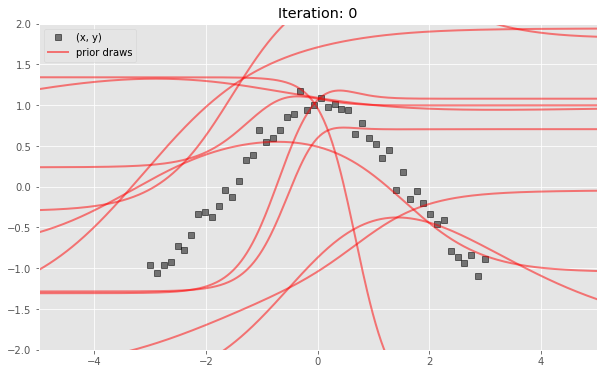

In [7]:
# FIRST VISUALIZATION (prior)

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

In [9]:
outputs

array([[ 1.2005908 ,  1.1992121 ,  1.1978064 , ..., -0.10589993,
        -0.10617119, -0.10643756],
       [ 2.310995  ,  2.3105974 ,  2.3101945 , ...,  0.24208906,
         0.22497004,  0.20787686],
       [-0.06589741, -0.06238621, -0.05886608, ...,  0.19141203,
         0.19405264,  0.19668347],
       ...,
       [ 3.552633  ,  3.5512447 ,  3.549823  , ..., -2.5335715 ,
        -2.5338278 , -2.5340781 ],
       [-0.982539  , -0.9825199 , -0.98250073, ..., -0.6442266 ,
        -0.64410645, -0.6439858 ],
       [-1.4007956 , -1.400447  , -1.4000939 , ...,  1.3532985 ,
         1.3667433 ,  1.3802285 ]], dtype=float32)

In [8]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
out = inference.run(n_iter=1000, n_samples=5)

/home/jjh/anaconda3/envs/edward_py2/lib/python2.7/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 9s | Loss: 10.069


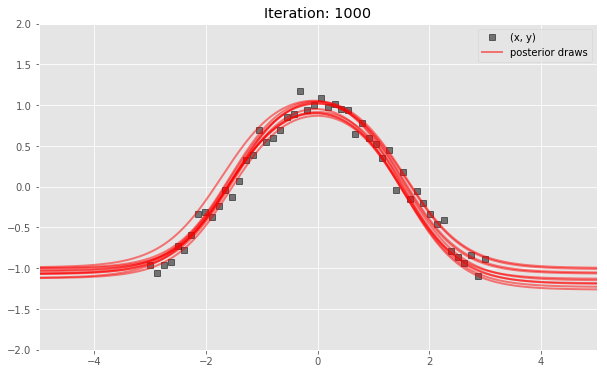

In [9]:
# SECOND VISUALIZATION (posterior)

outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

In [10]:
a = qW_0.sample(1000)
mya = a.eval()

(array([  7.,  31.,  77., 157., 244., 236., 159.,  57.,  28.,   4.]),
 array([0.90403515, 0.9166673 , 0.92929935, 0.9419315 , 0.9545636 ,
        0.96719575, 0.9798278 , 0.99245995, 1.005092  , 1.0177242 ,
        1.0303563 ], dtype=float32),
 <a list of 10 Patch objects>)

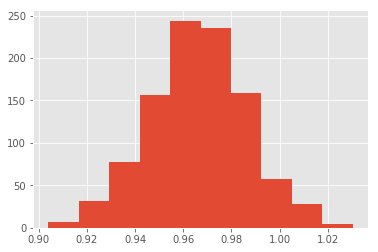

In [11]:
plt.hist(mya[:,0,0])

(array([  4.,  13.,  68., 189., 278., 246., 144.,  43.,  12.,   3.]),
 array([-1.033313  , -1.0184145 , -1.003516  , -0.98861736, -0.9737188 ,
        -0.9588203 , -0.94392174, -0.9290232 , -0.9141246 , -0.89922607,
        -0.88432753], dtype=float32),
 <a list of 10 Patch objects>)

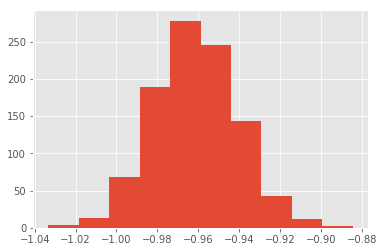

In [12]:
plt.hist(mya[:,0,1])

In [40]:
help(ed.models.Empirical)

Help on class Empirical in module abc:

class Empirical(edward.models.random_variable.RandomVariable, edward.models.empirical.distributions_Empirical)
 |  Empirical random variable.
 |  
 |  #### Examples
 |  
 |  ```python
 |  # 100 samples of a scalar
 |  x = Empirical(params=tf.zeros(100))
 |  assert x.shape == ()
 |  
 |  # 5 samples of a 2 x 3 matrix
 |  dp = Empirical(params=tf.zeros([5, 2, 3]))
 |  assert x.shape == (2, 3)
 |  ```
 |  
 |  Method resolution order:
 |      Empirical
 |      edward.models.random_variable.RandomVariable
 |      edward.models.empirical.distributions_Empirical
 |      tensorflow.python.ops.distributions.distribution.Distribution
 |      tensorflow.python.ops.distributions.distribution._BaseDistribution
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Initialize an `Empirical` random variable.
 |      
 |      Args:
 |        params: tf.Tensor.
 |        Collection of samples. Its outer (left-m

In [42]:
x = ed.models.Empirical(params=tf.zeros(100))
assert x.shape == ()

In [45]:
print(tf.Session().run(x)[3:10])

IndexError: invalid index to scalar variable.